In [25]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import PolyCollection

from datetime import datetime

# Function to convert string to datetime
def datetime_from_str(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S.%f') if '.' in date_str else datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')


In [13]:
import psycopg2

conn = psycopg2.connect(
    host='localhost',
    database='cadets_e3',
    user='rosendahl',
)
conn.set_session(readonly=True)
# get cursor
cur = conn.cursor()


In [12]:
# find times where excecutables pEja72mA or vUgefal are executed
# first find subject ids
query = '''
select distinct subject_uuid
from event
where properties_map_exec = 'pEja72mA'
or properties_map_exec = 'vUgefal'
'''

cur.execute(query)
subject_ids = cur.fetchall()
subject_ids = [s[0] for s in subject_ids]

print(f'found {len(subject_ids)} subjects')

# now find beginning end end times
query = '''
select min(ts), max(ts)
from event
where subject_uuid = %s
'''

for s in subject_ids:
    cur.execute(query, (s,))
    start, end = cur.fetchone()
    print(f'subject: {s}, start: {start}, end: {end}')

found 3 subjects
subject: 4FB0BFEA-3F1C-11E8-A5CB-3FA3753A265A, start: 2018-04-13 15:12:26.344650, end: 2018-04-13 15:21:45.634633
subject: D3822AFC-39AF-11E8-BF66-D9AA8AFF4A69, start: 2018-04-06 17:33:16.536155, end: 2018-04-06 18:08:46.906108
subject: DD6625DA-3F1C-11E8-A5CB-3FA3753A265A, start: 2018-04-13 15:16:24.104639, end: 2018-04-13 15:16:24.144638


In [19]:
# find the biggest time gaps in the data
# for every sequence, get the start and the end time
query = '''
select timestamp_begin, timestamp_end
from sequence
order by timestamp_begin asc;
'''
cur.execute(query)
timestamps = cur.fetchall()
timestamps = [(datetime_from_str(str(t[0]).split('.')[0]), datetime_from_str(str(t[1]).split('.')[0])) for t in timestamps]

In [20]:
# build a list of timespans from the sequences

result = []

current_begin = timestamps[0][0]
current_end = timestamps[0][1]

for t in timestamps:
    # if the next sequence start within the current sequence, extend the current sequence, else add the current sequence to the result
    if t[0] <= current_end:
        current_end = t[1]
    else:
        result.append((current_begin, current_end))
        current_begin = t[0]
        current_end = t[1]
    

In [23]:
print(f'found {len(result)} sequences')

# print first 5 sequences
for i in range(5):
    print(result[i])
    
# find biggest gaps
gaps = []
for i in range(1, len(result)):
    gap = result[i][0] - result[i-1][1]
    gaps.append((gap, result[i-1][1], result[i][0]))
    
gaps.sort(reverse=True)
# print first 5 gaps
for i in range(5):
    print(gaps[i])

found 42864 sequences
(datetime.datetime(2018, 4, 3, 0, 7, 41), datetime.datetime(2018, 4, 3, 0, 7, 43))
(datetime.datetime(2018, 4, 3, 0, 7, 44), datetime.datetime(2018, 4, 3, 0, 7, 45))
(datetime.datetime(2018, 4, 3, 0, 7, 46), datetime.datetime(2018, 4, 3, 0, 7, 46))
(datetime.datetime(2018, 4, 3, 0, 8, 13), datetime.datetime(2018, 4, 3, 0, 8, 17))
(datetime.datetime(2018, 4, 3, 0, 8, 19), datetime.datetime(2018, 4, 3, 0, 8, 19))
(datetime.timedelta(seconds=6739), datetime.datetime(2018, 4, 6, 18, 8, 53), datetime.datetime(2018, 4, 6, 20, 1, 12))
(datetime.timedelta(seconds=4814), datetime.datetime(2018, 4, 11, 21, 16, 13), datetime.datetime(2018, 4, 11, 22, 36, 27))
(datetime.timedelta(seconds=132), datetime.datetime(2018, 4, 3, 14, 46, 5), datetime.datetime(2018, 4, 3, 14, 48, 17))
(datetime.timedelta(seconds=81), datetime.datetime(2018, 4, 3, 6, 1), datetime.datetime(2018, 4, 3, 6, 2, 21))
(datetime.timedelta(seconds=60), datetime.datetime(2018, 4, 13, 5, 38, 1), datetime.datetim

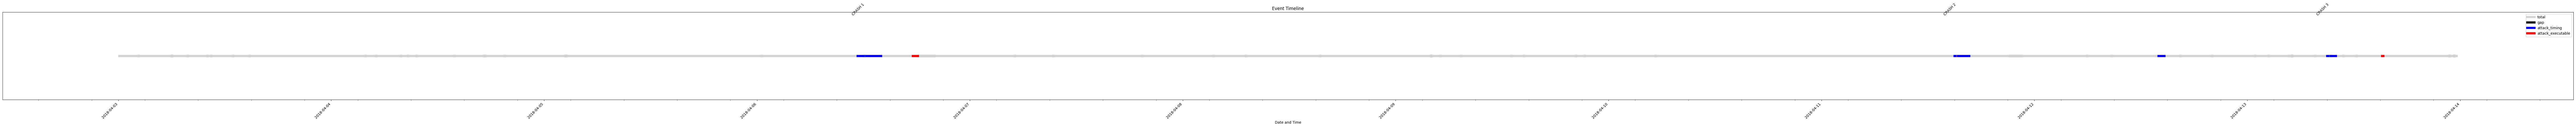

In [31]:
start = '2018-04-03 00:07:41.813350'
end = '2018-04-13 23:35:58.953969'

data = []
data.append((datetime_from_str(start), datetime_from_str(end), 'total'))

#for timestamp in timestamps:
#    data.append((timestamp[0], timestamp[1], 'total'))

# for first 100 gaps
for i in range(100):
    data.append((gaps[i][1], gaps[i][2], 'gap'))


data += [
    (datetime_from_str(start), datetime_from_str(end), 'total'),
    (datetime_from_str('2018-04-06 11:20:00'), datetime_from_str('2018-04-06 14:00:00'), 'attack_timing'),
    (datetime_from_str('2018-04-11 15:00:00'), datetime_from_str('2018-04-11 16:40:00'), 'attack_timing'),
    (datetime_from_str('2018-04-12 14:00:00'), datetime_from_str('2018-04-12 14:40:00'), 'attack_timing'),
    (datetime_from_str('2018-04-13 09:00:00'), datetime_from_str('2018-04-13 10:00:00'), 'attack_timing'),
    (datetime_from_str('2018-04-13 15:12:26.344650'), datetime_from_str('2018-04-13 15:21:45.634633'), 'attack_executable'),
    (datetime_from_str('2018-04-06 17:33:16.536155'), datetime_from_str('2018-04-06 18:08:46.906108'), 'attack_executable'),
    (datetime_from_str('2018-04-13 15:16:24.104639'), datetime_from_str('2018-04-13 15:16:24.144638'), 'attack_executable'),
]

# Specific points in time to highlight
highlight_points = [
    (datetime_from_str('2018-04-06 12:09:00'), 'CRASH 1'),
    (datetime_from_str('2018-04-11 15:15:00'), 'CRASH 2'),
    (datetime_from_str('2018-04-13 09:16:00'), 'CRASH 3')
]

# Set up the plot
fig, ax = plt.subplots(figsize=(100, 5))

# Define colors for each category
colors = {
    'total': 'lightgrey',
    'attack_timing': 'blue',
    'attack_executable': 'red',
    'gap': 'black',
}

# Plot each time span
for start, end, label in data:
    ax.plot([start, end], [1, 1], color=colors[label], lw=6, label=label)

# Highlight specific points
for point, label in highlight_points:
    ax.plot(point, 1, '|')  # 'ko' is a black circle marker
    ax.text(point, 1.05, label, rotation=45, ha='right', va='bottom')
    

# Format the x-axis
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Remove y-axis
ax.yaxis.set_visible(False)

# Add a legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

# Add title and labels
plt.title('Event Timeline')
plt.xlabel('Date and Time')

# Show plot
plt.tight_layout()
plt.show()
